**Summary**

In this tutorial we will enrich Acropora digitifera observations with bathymetry information.

We will first download GBIF occurrences for Acropora digitifera. If you do not want to create a GBIF account, you can use your own dataset instead (DarwinCore or csv), or the packaged DarwinCore archive.

An enrichment file will be created where data will be added, as we download environmental variables for this dataset.

Afterwards, we will pick a variable id from the [catalog file](geoenrich/data/catalog.csv). If the variable you want is not available, feel free to update the *catalog.csv* file with new rows (see [installation instructions](https://geoenrich.readthedocs.io/en/latest/install.html)).


# Load occurrence data and create enrichment file

In [ ]:
import os
from geoenrich.dataloader import *
from geoenrich.enrichment import create_enrichment_file

#### If you are using your own dataset (DarwinCore format)

NB: A DarwinCore archive is bundled into the package for user testing (GBIF Occurrence Download [10.15468/dl.megb8n](https://doi.org/10.15468/dl.megb8n)).

If you don't have a dataset and you don't want to register to GBIF yet you can use this one.

In [ ]:
example_path = os.path.split(geoenrich.__file__)[0] + '/data/AcDigitifera.zip'
geodf = open_dwca(path = example_path)

#### If you are using your own dataset (csv format)

Fill in the path to your csv and the compulsory column names.

Additional arguments are passed down to pandas.read_csv

In [ ]:
geodf = import_csv(path = '', id_col = '', date_col = '', lat_col = '',
                           lon_col = '', depth_col = '')

#### If you do not have occurrences but want to enrich arbitrary areas

See documentation for information about input file format.

In [ ]:
example_path = os.path.split(geoenrich.__file__)[0]  + '/data/areas.csv'
df = load_areas_file(example_path)

#### Create enrichment file

In [ ]:
# For occurrences
dataset_ref_occ = 'occurrences'
create_enrichment_file(geodf, dataset_ref_occ)

In [ ]:
# For areas
dataset_ref_areas = 'areas'
create_enrichment_file(df, dataset_ref_areas)

# Enrich

In [ ]:
from geoenrich.enrichment import enrich

#### Define enrichment scope

In [23]:
var_id = 'bathymetry'
geo_buff = 115       # kilometers
time_buff = (-7, 0)  # Download data from 7 days before occurrence date to occurrence date
                     # (for datasets where time is a dimension)

Only enrich a small slice first to check speed.

In [ ]:
dataset_ref_occ = 'occurrences'
enrich(dataset_ref_occ, var_id, geo_buff, time_buff, slice = (0, 100))

For large areas, use downsample argument to download only part of available data (to reduce download time)

In [ ]:
# Skip 9 latitude and longitude points for each downloaded point.
dataset_ref_areas = 'areas'
downsample = {'latitude': 9, 'longitude': 9}
enrich(dataset_ref_areas, var_id, downsample = downsample)

# Data retrieval

In [ ]:
from geoenrich.enrichment import read_ids, enrichment_status
from geoenrich.exports import retrieve_data
dataset_ref = 'occurrences'

#### Check the enrichment status of the dataset.

In [ ]:
enrichment_status(dataset_ref)


#### Request data from local storage for the first row of our dataset.

In [39]:
ids = read_ids(dataset_ref)
occ_id = ids[50]
var_id = 'bathymetry'
output = retrieve_data(dataset_ref, occ_id, var_id, shape = 'buffer')

6632 occurrences were loaded from enrichment file


#### Unpack and plot data

In [40]:
data = output['values']
unit = output['unit']
coords = output['coords']

<IPython.core.display.Javascript object>


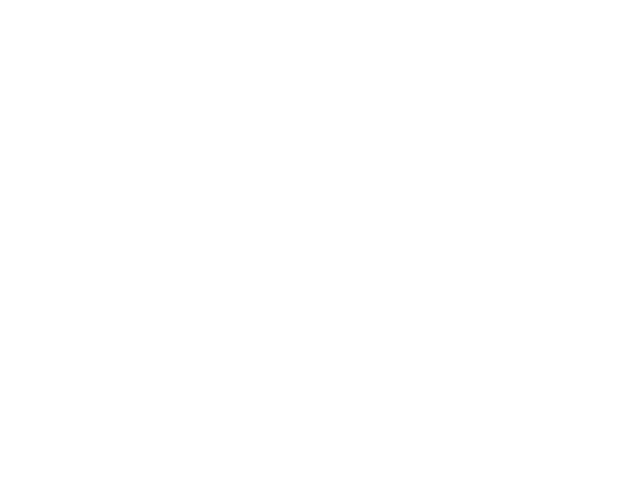

In [41]:
from shapely import wkt
from matplotlib import pyplot as plt
%matplotlib notebook

# Get latitude and longitude values for the requested data
lat_dim = [c[0] for c in coords].index('latitude')
lon_dim = [c[0] for c in coords].index('longitude')
lats = coords[lat_dim][1]
longs = coords[lon_dim][1]

# Get coordinates for the occurrence point
filepath = biodiv_path + dataset_ref + '.csv'
df = pd.read_csv(filepath, parse_dates = ['eventDate'], infer_datetime_format = True, index_col = 0)
point = wkt.loads(df.loc[occ_id, 'geometry'])

# Plot
extent = [longs[0] , longs[-1], lats[0] , lats[-1]]
plt.imshow(data, extent = extent, origin = 'lower')
plt.title(var_id + ' (' + unit + ')')
plt.colorbar()
plt.scatter([point.x], [point.y], c='black', marker='x')

# NB: If your data has time or depth dimensions, you will have to pick a slice of the data array to be able to plot it

# Using occurrence data from GBIF

In [ ]:
from geoenrich.dataloader import *

#### Get GBIF id for the taxon of interest

In [ ]:
taxKey = get_taxon_key('Acropora digitifera')

#### Request an archive with all occurrences of this taxon

In [ ]:
request_id = request_from_gbif(taxKey)

#### Download request

For large requests, some waiting time is needed for the archive to be ready.

In [44]:
download_requested(request_key = request_id)

Requested data not available. Request status: RUNNING


#### You can then load data using open_dwca

In [ ]:
geodf = open_dwca(taxonKey = taxKey)